# Chaper5. 합성곱 신경망 I

In [ ]:
import pandas as pd

df = pd.DataFrame({
    'a1': [1, None, 3, None, 5, None],
    'x1': [10, 20, 30, 20, 10, 30],
    'x2': [1, 2, 1, 2, 1, 2],
    'x3': ['A', 'B', 'A', 'B', 'A', 'B']
})

# a1 컬럼에서 결측치가 있는 행들을 선택합니다.
missing_rows = df[df['a1'].isna()]

# x1, x2, x3 값을 그룹으로 묶어 최빈값을 구합니다.
mode_values = missing_rows[['x1', 'x2', 'x3']].mode().iloc[0]

# 결측치를 최빈값으로 대체합니다.
df.loc[df['a1'].isna(), ['x1', 'x2', 'x3']] = mode_values.values

print(df)

    a1  x1  x2 x3
0  1.0  10   1  A
1  NaN  20   2  B
2  3.0  30   1  A
3  NaN  20   2  B
4  5.0  10   1  A
5  NaN  20   2  B


### 합성곱층의 필요성

이미지 분석은 3 x 3 배열을 오른쪽과 같이 펼쳐서(flatten) 각 픽셀에 가중치를 곱하여 은닉층으로 전달하게 됩니다.

하지만 그림에서 보이는 것처럼 이미지를 펼쳐서 분석하면 데이터의 공간적 구조를 무시하게 되는데, 이것을 방지하려고 도입된 것이 합성곱층입니다.

### 합성곱 신경망 구조

1. 입력층
2. 합성곱층
3. 풀링층
4. 완전연결층
5. 출력층

합성곱층은 입력 데이터에서 특성을 추출하는 역할을 수행합니다.

풀링층은 합성곱층과 유사하게 특성 맵의 차원을 다운 샘플링하여 연산량을 감소시키고, 주요한 특성 벡터를 추출하여 학습을 효과적으로 할 수 있게 합니다.

**다운 샘플링** : 이미지를 축소하는 것입니다.

풀링 연산에는 두 가지가 사용됩니다.
- 최대 풀링 : 대상 영역에서 최대값을 추출
- 평균 풀링 : 대상 영역에서 평균을 반환
  - 평균 풀링은 각 커널 값을 평균화 시켜 중요한 가중치를 갖는 값의 특성이 희미해질 수 있기 때문입니다.

완전 연결층은 합성곱층과 풀링층을 거치면서 차원이 축소된 특성 맵은 최종적으로 완전연결층(fully connected layer)으로 전달됩니다.
이 과정에서 이미지는 3차원 벡터에서 1차원 벡터로 펼쳐지게(flatten) 됩니다.

출력층에서는 소프트맥스 활성화 함수가 사용되는데, 입력받은 값을 0~1 사이의 값으로 출력합니다. 따라서 마지막 출력층의 소프트맥스 함수를 사용하여 이미지가 각 레이블에 속할 확률 값이 출력되며, 이때 가장 높은 확률 값을 가지는 레이블이 최종 값으로 선정됩니다.

### 1D, 2D, 3D 합성곱

합성곱은 이동하는 방향의 수와 출력 형태에 따라 1D, 2D, 3D로 분류할 수 있습니다.

1D 합성곱은 필터가 시간을 축으로 좌우로만 이동할 수 있는 합성곱입니다.

2D 합성곱은 필터가 방향 두 개로 움직이는 형태입니다.

3D 합성곱은 필터가 움직이는 방향이 세 개있습니다.

3D 입력을 갖는 2D 합성곱은 입력이 3D 형태임에도 출력 형태가 3D가 아닌 2D 형태입니다.
- LeNet-5, VGG

1x1 합성곱은 3D 형태로 입력됩니다. 입력(W, H, L)에 1x1xL 필터는 (1, 1, L)를 적용
- GoogleLeNet

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

**GPU 사용**

일반적으로 하나의 GPU를 사용할 때는
```
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Net()
model.to(device)
```

하지만 사용하는 PC에서 다수의 GPU를 사용한다면 nn.DataParallel을 사용
```
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Net()
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(net)
model.to(device)
```
nn.DataParallel을 사용할 경우 배치 크기(batch size)가 알아서 각 GPU로 분배되는 방식으로 작동합니다. 따라서 GPU 수만큼 배치 크기도 늘려 주어야 합니다.

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST('../PytorchStudy/chap05data', download = True, transform = transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST('../PytorchStudy/chap05data', download = True, train = False, transform = transforms.Compose([transforms.ToTensor()]))
# transforms : 이미지를 텐서(0~1)로 변경합니다.

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../PytorchStudy/chap05data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../PytorchStudy/chap05data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../PytorchStudy/chap05data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../PytorchStudy/chap05data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../PytorchStudy/chap05data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../PytorchStudy/chap05data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../PytorchStudy/chap05data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../PytorchStudy/chap05data/FashionMNIST/raw



In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 100, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100, shuffle = True)

In [ ]:
img_xy = np.random.randint(len(train_dataset))

In [ ]:
img_xy

25079

In [ ]:
print(train_dataset[img_xy][0]) # data
print(train_dataset[img_xy][1]) # target

tensor([[[0.0000, 0.0000, 0.0118, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.1725, 0.5294, 0.5686, 0.2196, 0.0941, 0.0588, 0.1490,
          0.5686, 0.6784, 0.2588, 0.0627, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.1490, 0.5804, 0.8392,
          0.9373, 0.9569, 0.8353, 0.9373, 0.9922, 0.9961, 1.0000, 1.0000,
          0.9608, 0.8549, 0.9569, 0.9529, 0.9137, 0.6314, 0.0627, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0039, 0.0000, 0.1569, 0.8353, 0.8784, 0.8275,
          0.8000, 0.7725, 0.7765, 0.7686, 0.8588, 0.8471, 0.8706, 0.8510,
          0.7725, 0.7765, 0.7882, 0.7882, 0.8196, 0.8745, 0.8392, 0.1333,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.7176, 0.8196, 0.7725, 0.7843,
          0.7882, 0.7882, 0.7843, 0.7765, 0.7412, 0.7647, 0.7529, 0.7373,
          0.7725, 0.7843, 0.7882, 0.8039, 0.7804, 0.7686,

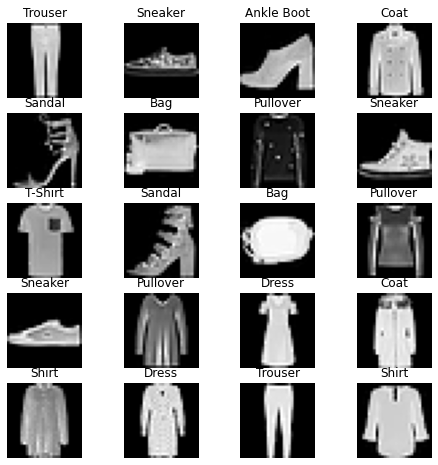

In [ ]:
labels_map = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
              5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}

fig = plt.figure(figsize = (8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows + 1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0, :, :] # train_dataset[img_xy][0][0]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap = 'gray')

plt.show() # 20개의 이미지 데이터를 시각적으로 표현

In [ ]:
import numpy as np
examp = np.arange(0, 100, 3)
examp.resize(8, 4)
examp

array([[ 0,  3,  6,  9],
       [12, 15, 18, 21],
       [24, 27, 30, 33],
       [36, 39, 42, 45],
       [48, 51, 54, 57],
       [60, 63, 66, 69],
       [72, 75, 78, 81],
       [84, 87, 90, 93]])

In [ ]:
examp = np.arange(0, 500, 3)
examp.resize(3, 5, 5) # 5x5 3개
examp

array([[[  0,   3,   6,   9,  12],
        [ 15,  18,  21,  24,  27],
        [ 30,  33,  36,  39,  42],
        [ 45,  48,  51,  54,  57],
        [ 60,  63,  66,  69,  72]],

       [[ 75,  78,  81,  84,  87],
        [ 90,  93,  96,  99, 102],
        [105, 108, 111, 114, 117],
        [120, 123, 126, 129, 132],
        [135, 138, 141, 144, 147]],

       [[150, 153, 156, 159, 162],
        [165, 168, 171, 174, 177],
        [180, 183, 186, 189, 192],
        [195, 198, 201, 204, 207],
        [210, 213, 216, 219, 222]]])

In [ ]:
examp[2][0][3]

159

In [ ]:
class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(in_features = 784, out_features = 256)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features = 256, out_features = 128)
    self.fc3 = nn.Linear(in_features = 128, out_features = 10)

  def forward(self, input_data):
    out = input_data.view(-1, 784)
    out = F.relu(self.fc1(out))
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

클래스 형태의 모델은 항상 torch.nn.Module을 상속받습니다.

_ _init_ _()은 객체가 갖는 속성 값을 초기화하는 역할을 하며,

객체가 생성될 때 자동으로 호출됩니다.

super(FashionDNN, self)._ _init_ _()은 FashionDNN이라는 부모(super)

클래스를 상속받겠다는 의미로 이해하면 됩니다.

In [ ]:
def add(num1, num2):
  result = num1 + num2
  return result

print(add(3, 4))
print(add(1, 2))

7
3


In [ ]:
class Calc:
  def __init__(self): # 객체를 생성할 때 호출하면 실행되는 초기화 함수
    self.result = 0

  def add(self, num1, num2):
    self.result = num1 + num2
    return self.result

obj1 = Calc()
obj2 = Calc()

print(obj1.add(3, 4))
print(obj2.add(1, 2))

# 결과로 볼 수 있듯이 두 개의 객체는 독립적으로 연산됩니다. 개별적 함수로 구현했다면 복잡했을 코드가 클래스 사용으로 간결해졌습니다.

7
3


nn은 딥러닝 모델(네트웨크) 구성에 필요한 모듈이 모여 있는 패키지이며, Linear는 단순 선형 회귀 모델을 만들 때 사용합니다.
```
nn.Linear(in_features = 784, out_features = 256)
```
실제로 데이터 연산이 진행되는 forward() 부분에는 첫 번째 파라미터 값만 넘겨주게 되며 두번째 파라미터에서 정의된 크기가 forward() 연산의 결과가 됩니다.

torch.nn.Dropout(p)는 p만큼의 비율로 텐서의 값이 0이 되고, 0이 되지 않는 값들은 기존 값에 (1/(1-p))만큼 곱해져 커집니다. 예를 들어 p = 0.3이라는 의미는 전체 값 중 0.3의 확률로 0이 된다는 것이며, 0이 되지 않는 0.7에 해당하는 값은 (1/0.7)만큼 커집니다.

forward() 함수는 모델이 학습 데이터를 입력받아서 순전파(forward propagation)학습 시키며, 반드시 forward라는 이름의 함수여야 합니다.
즉, forward()는 모델이 학습 데이터를 입력받아서 순전파 연산을 진행하는 함수이며, 객체를 데이터와 함께 호출하면 자동으로 실행됩니다. 이때 순전파 연산이란 H(x)식에 입력 x로부터 예측된 y를 얻는 것입니다.

파이토치에서 사용하는 뷰(view)는 넘파이의 reshape과 같은 역할로 텐서의 크기를 변경해 주는 역할을 합니다. 따라서 input_data.view(-1, 784)는 input_data를 (?, 784)의 크기로 변경하라는 의미입니다.
이때 첫 번째 차원(-1)은 사용자가 잘 모르겠으니 파이토치에 맡기겠다는 의미이고, 두 번째 차원의 길이는 784를 가지도록 하라는 의미입니다. 다시 말해 2차원 텐서로 변경하되 (?, 784)의 크기로 변경하라는 의미입니다.

활성화 함수를 지정할 때는 다음 두가지 방법이 가능합니다.
- F.relu() : forward()함수에서 정의
- nn.ReLU() : _ _init_ _()함수에서 정의

활성화 함수 사용에 한정하여 이 둘 간의 차이는 간단히 사용하는 위치라고 할 수 있습니다. 하지만 근본적으로는 nn.functional() (혹은 F.xx())와 nn.xx()는 사용 방법에 차이가 있습니다.

```
import torch
import torch.nn as nn

inputs = torch.randn(64, 3, 244, 244)
conv = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1) # 세 개의 채널이 입력되어 64개의 채널이 출력되기 위한 연산으로 3x3 크기의 커널을 사용
outputs = conv(inputs)
layer = nn.Conv2d(1, 1, 3)
```

그리고 nn.functional을 사용하는 예시
```
import torch.nn.functional as F

inputs = torch.randn(64, 3, 244, 244)
weight = torch.randn(64, 3, 3, 3)
bias = torch.randn(64)
outputs = F.conv2d(inputs, weights, bias, padding = 1)
```

nn.Conv2d에서 input_channel과 output_channel을 사용해서 연산했다면 functional.conv2d는 입력과 가중치(weight) 자체를 직접 넣어 줍니다. 이때 직접 넣어 준다는 의미는 가중치를 전달해야 할 때마다 가중치 값을 새로 정의해야 함을 의미합니다. 그 외에 채워야 하는 파라미터들은 nn.Conv2d와 비슷합니다.


In [ ]:
learning_rate = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss() # 분류 문제에서 사용되는 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50): # count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))

        outputs = model(test)
        predictions = torch.max(outputs, dim = 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct * 100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if (count % 500) == 0: # <=> if not (count % 500):
      print('iteration: {}, loss: {}, Accuracy: {}%'.format(count, loss.data, accuracy))


iteration: 500, loss: 0.3848488926887512, Accuracy: 87.02999877929688%
iteration: 1000, loss: 0.3339693546295166, Accuracy: 86.4000015258789%
iteration: 1500, loss: 0.3119526505470276, Accuracy: 86.72000122070312%
iteration: 2000, loss: 0.33798789978027344, Accuracy: 87.0999984741211%
iteration: 2500, loss: 0.27304312586784363, Accuracy: 87.43000030517578%
iteration: 3000, loss: 0.3490356504917145, Accuracy: 87.7699966430664%


Autograd는 자동 미분을 수행하는 파이토치의 핵심 패키지로, 자동 미분에 대한 값을 저장하기 위해 테이프(tape)를 사용합니다. 순전파(forward) 단계에서 테이프는 수행하는 모든 연산을 저장합니다. 그리고 역전파(backward) 단계에서 저장된 값들을 꺼내서 사용합니다. 즉, Autograd는 Variable을 사용해서 역전파를 위한 미분 값을 자동으로 계산해줍니다. 따라서 자동 미분을 계산하기 위해서는 torch.autograd 패키지 안에 있는 Variable을 이용해야 동작합니다.

In [ ]:
class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1), # in_channels: 입력 채널의 수 (흑백 이미지 1, RGB값을 가진 이미지는 3) = 깊이를 의미함
        # 필터(fileter) 혹은 커널(kernel)을 직사각형으로 사용하고 싶다면 ex) kernel_size = (3, 5) 이런식으로 지정
        # padding: 패딩 크기를 의미하는 것으로 출력 크기를 조정하기 위해 입력 데이터 주위에 0을 채웁니다. 패딩 값이 클수록 출력 크기도 커집니다.
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2), # stride 크기가 커지면 출력 크기는 작아집니다.
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.fc1 = nn.Linear(in_features = 64 * 6 * 6, out_features = 600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features = 600, out_features = 120)
    self.fc3 = nn.Linear(in_features = 120, out_features = 10) # 마지막 계층의 out_features는 클래스 개수를 의미

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

nn.Linear(in_features = 64*6*6, out_features = 600)
이 부분에서 in_features는 앞에서 사용했던 Conv2d에서 사용하는 하이퍼파라미터 값들에 따라 출력 크기가 달라집니다. 즉, 패딩과 스트라이드의 값에 따라 출력 크기가 달라집니다. 이렇게 줄어든 출력 크기는 최종적으로 분류를 담당하는 완전연결층(fully connected layer)으로 전달됩니다.

in_features: 입력 데이터의 크기를 의미합니다. 중요한 것은 이전까지 수행했던 Conv2d, MaxPool2d는 이미지 데이터를 입력으로 받아 처리했습니다. 하지만 그 출력 결과를 완전연결층으로 보내기 위해서는 1차원으로 변경해주어야 하는데, 공식은


**Conv2d 계층에서의 출력 크기 구하는 공식**

출력 크기 = (W - F + 2P)/S + 1
- W: 입력 데이터의 크기
- F: 커널 크기
- P: 패딩 크기
- S: 스트라이드

그래서 계산해보면 784가 나오고
입력 데이터의 크기는 784이며, stride가 명시되어 있지 않다면 stride는 기본값으로 (1,1)입니다.

계산 결과 적용하면 출력의 형태는 [32, 784, 784]가 됩니다.

**MaxPool2d 계층에서의 출력 크기 구하는 공식**
- 출력 크기 = IF/F
  - IF: 입력 필터의 크기(input_filter_size, 또한 바로 앞의 Conv2d의 출력 크기이기도 합니다)

  - F: 커널 크기(kernel_size)

예를 들어 첫 번째 MaxPool2d 계층은 다음과 같습니다.
```
nn.MaxPool2d(kernel_size = 2, strides = 2)
```
따라서 출력 크기는 784 / 2 = 392

계산 결과를 적용하면 출력의 형태는 [32, 392, 392]가 됩니다. 그리고 가장 앞의 32는 바로 앞 Conv2d 계층의 out_channels입니다.

In [ ]:
learning_rate = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss() # 분류 문제에서 사용되는 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [ ]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50): # count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))

        outputs = model(test)
        predictions = torch.max(outputs, dim = 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct * 100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if (count % 500) == 0: # <=> if not (count % 500):
      print('iteration: {}, loss: {}, Accuracy: {}%'.format(count, loss.data, accuracy))


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


iteration: 500, loss: 0.22821378707885742, Accuracy: 87.75%
iteration: 1000, loss: 0.39964866638183594, Accuracy: 89.36000061035156%
iteration: 1500, loss: 0.19099180400371552, Accuracy: 89.77999877929688%
iteration: 2000, loss: 0.28995808959007263, Accuracy: 89.16000366210938%
iteration: 2500, loss: 0.1118820309638977, Accuracy: 90.69999694824219%
iteration: 3000, loss: 0.15356144309043884, Accuracy: 89.79000091552734%


### 전이 학습

전이 학습을 위한 방법으로는
- 특성 추출
- 미세 조정 기법

특성 추출 기법

특성 추출(feature extractor)은 ImageNet 데이터셋으로 사전 훈련된 모델을 가져온 후 마지막에 완전연결층 부분만 새로 만듭니다. 즉, 학습할 때는 마지막 완전연결층(이미지 카테고리를 결정하는 부분)만 학습하고 나머지 계층들은 학습되지 않도록 합니다.

특성 추출은 이미지 분류를 위해 두 부분으로 구성됩니다.
- 합성곱층: 합성곱층과 풀링층으로 구성
- 데이터 분류기(완전연결층): 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스를 분류하는 부분

사전 훈련된 네트워크의 합성곱층(가중치 고정)에 새로운 데이터를 통과시키고, 그 출력을 데이터 분류기에서 훈련시킵니다.

여기에서 사용 가능한 이미지 분류 모델은
- Xception
- Inception V3
- ResNet50
- VGG16
- VGG19
- MobileNet

In [ ]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import time
import copy
import glob
import cv2 # 앞에서 설치한 opencv 라이브러리
import shutil

import torch
import torchvision # 컴퓨터 비전 용도의 패키지
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용되는 패키지
import torchvision.models as models # 다양한 파이토치 네트워크를 사용할 수 있도록 도와주는 패키지
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [ ]:
import zipfile

zipfile.ZipFile('../content/catanddog.zip').extractall('../content/catanddog')

In [ ]:
data_path = '../content/catanddog' # 이미지 데이터가 위치한 경로 저장

transform = transforms.Compose([
    transforms.Resize([256, 256]), # 이미지의 크기를 조정, 즉, 256x256 크기로 이미지 데이터를 조정합니다.
    transforms.RandomResizedCrop(224), # 이미지를 랜덤한 크기 및 비율로 자릅니다.
    transforms.RandomHorizontalFlip(), # 이미지를 랜덤하게 수평으로 뒤집습니다.
    transforms.ToTensor() # 이미지 데이터를 텐서로 변환합니다.
])

# ImageFolder는 데이터로더가 데이터를 불러올 대상(혹은 경로)과 방법(혹은 전처리)을 정의함
train_dataset = torchvision.datasets.ImageFolder(
    data_path, # 불러올 데이터가 위치한 경로
    transform = transform # 이미지 데이터에 대한 전처리
)

# 데이터로더는 데이터를 불러오는 부분으로 앞에서 정의한 ImageFolder(train_dataset)을 데이터로더에 할당하는데, 이때 한 번에 불러올 데이터양을 결정하는 batch_size를 지정합니다.
# 또한 추가적으로 데이터를 무작위로 섞을 것인지도 설정합니다.
# num_workers : 데이터를 불러올 때 하위 프로세스를 몇 개 사용할지 설정하는데, 이때 너무 많은 하위 프로세스를 설정하게 되면 오류가 발생하거나 메모리 부족 현사이 발생할 수 있습니다.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, num_workers = 0, shuffle = True)

print(len(train_dataset))

483


**RandomResizedCrop**

RandomResizedCrop으로 데이터를 확장하는 방법에 대해 코드로 살펴볼 텐데, 먼저 다음 명령을 실행하여 mxnet을 설치합니다. mxnet 설치가 완료된 후에는 커널을 재시작해야 합니다.

In [ ]:
pip install mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 15.2 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


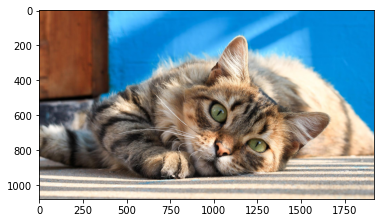

In [ ]:
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet.gluon.data.vision import transforms

example_image = mx.image.imread('../content/cat.jpg') # 예제를 진행할 이미지 불러오기
plt.imshow(example_image.asnumpy()) # 불러온 이미지 출력

In [ ]:
# 불러온 이미지에 RandomResizedCrop을 적용하기 위한 함수 생성
def show_images(imgs, num_rows, num_cols, scale = 2):
  aspect_ratio = imgs[0].shape[0]/imgs[0].shape[1] # 확장할 이미지의 크기 조정
  figsize = (num_cols * scale, num_rows * scale * aspect_ratio)
  _, axes = plt.subplots(num_rows, num_cols, figsize = figsize)
  for i in range(num_rows):
    for j in range(num_cols):
      axes[i][j].imshow(imgs[i * num_cols + j].asnumpy())
      axes[i][j].axes.get_xaxis().set_visible(False)
      axes[i][j].axes.get_yaxis().set_visible(False)
  plt.subplots_adjust(hspace = 0.1, wspace = 0)
  return axes

def apply(img, aug, num_rows = 2, num_cols = 4, scale = 3):
  Y = [aug(img) for _ in range(num_rows * num_cols)]
  show_images(Y, num_rows, num_cols, scale)

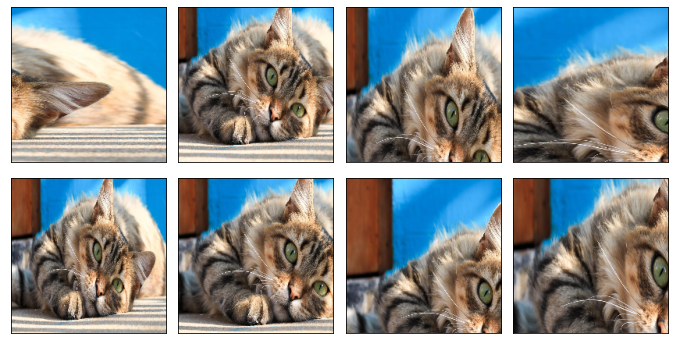

In [ ]:
shape_aug = transforms.RandomResizedCrop(size = (200, 200), # size: 출력할 크기를 200x200으로 조정합니다.
                                         scale = (0.1, 1), # scale: 면적 비율 0.1 ~ 1 (10 ~ 100%) 범위 내에서 무직위로 자릅니다.
                                         ratio = (0.5, 2)) # ratio: 면적의 너비와 높이 비율을 0.5 ~ 2 범위 내에서 무작위로 조절합니다.

apply(example_image, shape_aug)

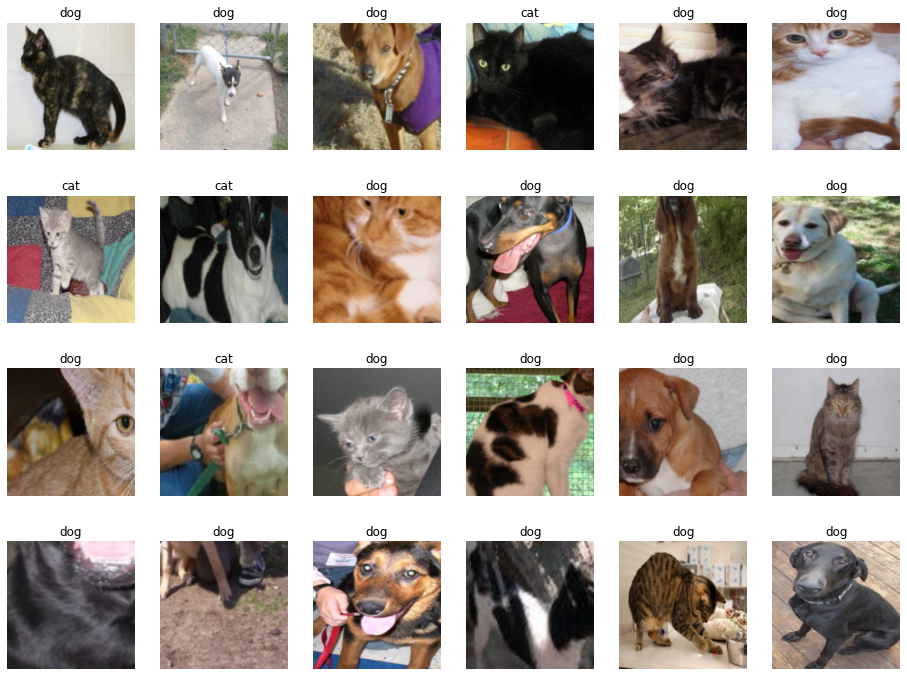

In [ ]:
import numpy as np

samples, labels = next(iter(train_loader))
classes = {0:'cat', 1:'dog'} # 개와 고양이에 대한 클래스로 구성
fig = plt.figure(figsize = (16, 24))
for i in range(24): # 24개의 이미지 데이터 출력
  a = fig.add_subplot(4, 6, i+1)
  a.set_title(classes[labels[i].item()]) # 레이블 정보(클래스)를 함께 출력
  a.axis('off')
  a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))
plt.subplots_adjust(bottom = 0.2, top = 0.6, hspace = 0)

반복자 (iterator, for 구문과 같은 효과)를 사용하려면 iter()와 next()가 필요합니다.
iter()는 전달된 데이터의 반복자를 꺼내 반환하며, next()는 그 반복자가 다음에 출력해야할 요소를 반환합니다. 즉, iter()로 반복자를 구하고 그 반복자를 next()에 전달하여 차례대로 꺼낼 수 있습니다. 앞의 코드에서 반복자는 train_loader가 되기 때문에 train_loader에서 samples와 labels의 값을 순차적으로 꺼내서 저장합니다. 간단히 정리하면 train_loader에서 데이터를 하나씩 꺼내 오겠다는 의미입니다.

np.transpose는 다음 그림과 같이 행과 열을 바꿈으로써 행렬의 차원을 바꾸어 줍니다.
일반적으로 행렬의 차원을 변경하는 이유는 행렬의 내적 연산 때문입니다.
A행렬의 행과 B행렬의 열의 수가 같아야 내적이 가능합니다. 행과 열의 수가 달라 불가능할 때는 np.transpose()나 np.reshape()등으로 차원을 조정해야 합니다.

In [ ]:
print(np.transpose(samples).shape), print(samples.shape)

torch.Size([224, 224, 3, 32])
torch.Size([32, 3, 224, 224])


(None, None)

In [ ]:
import torchvision.models as models

resnet18 = models.resnet18(pretrained = True) # pretrained = True 학습된 모델의 가중치 값을 사용, False로 하거나 쓰지 않으면 무작위 가중치 사용

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 내려받은 ResNet18의 합성곱층을 사용하되 파라미터에 대해서는 학습을 하지 않도록 고정시킵니다.

def set_parameter_requires_grad(model, feature_extraction = True):
  if feature_extraction:
    for param in model.parameters():
      param.requers_grad = False # 역전파 중 파라미터들에 대한 변화를 계산할 필요가 없음을 나타냅니다.

set_parameter_requires_grad(resnet18)

In [ ]:
# 내려받은 ResNet18의 마지막 부분에 완전연결층을 추가합니다. 추가된 완전연결층은 개와 고양이 클래스를 분류하는 용도로 사용됩니다.

resnet18.fc = nn.Linear(512, 2) # 2는 클래스가 두 개라는 의미

In [ ]:
# 모델의 파라미터 값 확인
for name, param in resnet18.named_parameters():
  if param.requires_grad:
    print(name, param.data)

conv1.weight tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2455e-01],
       

In [ ]:
model = models.resnet18(pretrained = True) # 모델의 객체 생성

for param in model.parameters(): # 모델의 합성곱층 가중치 고정
  param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters(): # 완전연결층은 학습
  param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters()) # 옵티마이저 정의
cost = torch.nn.CrossEntropyLoss() # 손실함수 정의
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import time

# 데이터 준비 및 네트워크 생성이 완료되었으므로, 이제 모델을 학습시켜야 합니다.
# 모델 학습을 위한 함수를 생성합니다.
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs = 13, is_train = True):
  since = time.time() # 컴퓨터의 현재 시각을 구하는 함수
  acc_history = []
  loss_history = []
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders: # 데이터로더에 전달된 데이터만큼 반복
      inputs = inputs.to(device)
      labels = labels.to(device)

      model.to(device)
      optimizer.zero_grad() # 기울기를 0으로 설정
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * inputs.size(0) # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
      running_corrects += torch.sum(preds == labels.data) # 출력 결과와 레이블이 동일한지 확인한 결과를 누적하여 저장

    epoch_loss = running_loss / len(dataloaders.dataset) # 평균 오차 계산
    epoch_acc = running_corrects.double() / len(dataloaders.dataset) # 평균 정확도 계산

    print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    if epoch_acc > best_acc:
      best_acc = epoch_acc

    acc_history.append(epoch_acc.item())
    loss_history.append(epoch_loss)
    torch.save(model.state_dict(), os.path.join('../content/catanddog/', '{0:0=2d}.pth'.format(epoch))) # 모델 재사용을 위해 저장해 둡니다.
    print()

  time_elapsed = time.time() - since # 실행시간(학습시간)을 계산
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best Acc: {:4f}'.format(best_acc))
  return acc_history, loss_history # 모델의 정확도와 오차를 반환


In [ ]:
# 마지막으로 ResNet18에 추가된 완전연결층을 학습

params_to_update = []
for name, param in resnet18.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    print('\t', name)

optimizer = optim.Adam(params_to_update)

	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.bn2.weight
	 layer

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss() # 손실함수 초기화
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.9520 Acc: 0.7019

Epoch 1/12
----------
Loss: 0.5306 Acc: 0.7805

Epoch 2/12
----------
Loss: 0.5316 Acc: 0.7971

Epoch 3/12
----------
Loss: 0.5018 Acc: 0.7971

Epoch 4/12
----------
Loss: 0.5034 Acc: 0.7971

Epoch 5/12
----------
Loss: 0.5056 Acc: 0.7971

Epoch 6/12
----------
Loss: 0.4939 Acc: 0.7971

Epoch 7/12
----------
Loss: 0.5017 Acc: 0.7930

Epoch 8/12
----------
Loss: 0.4995 Acc: 0.7971

Epoch 9/12
----------
Loss: 0.5168 Acc: 0.7992

Epoch 10/12
----------
Loss: 0.5075 Acc: 0.7971

Epoch 11/12
----------
Loss: 0.5122 Acc: 0.7930

Epoch 12/12
----------
Loss: 0.5115 Acc: 0.7909

Training complete in 29m 17s
Best Acc: 0.799172


In [ ]:
test_path = '/content/catanddog/test'

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

test_dataset = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform
)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, num_workers = 0, shuffle = True)

print(len(test_dataset))

98


In [ ]:
, dataloader
def eval_model(model, dataloaders, device):
  since = time.time()
  acc_history = []
  best_acc = 0.0

  saved_models = glob.glob('/content/catanddog/' + '*.pth') # glob는 현재 디렉터리에서 원하는 확장자의 파일들만 추출하여 가져올 때 사용
  saved_models.sort() # 불러온 .pth 파일들을 정렬
  print('saved_model', saved_models)

  for model_path in saved_models:
    print('Loading model', model_path)

    model.load_state_dict(torch.load(model_path)) # 저장된 state_dict() 매개변수들을 불러옵니다.
    model.eval() # 평가 모드, 학습할 때와 추론할 때 다르게 동작하는 layer들을 evaluation mode(평가모드)로 바꿔줍니다.
    model.to(device)
    running_corrects = 0

    for inputs, labels in dataloaders: # 테스트 반복
      inputs = inputs.to(device)
      labels = labels.to(device)

      with torch.no_grad(): # autograd를 사용하지 않겠다는 의미, model.eval()과 함께 쓰임
        outputs = model(inputs) # 데이터를 모델에 적용한 결과를 outputs에 저장

      _, preds = torch.max(outputs.data, 1) # 주어진 텐서 배열의 최댓값이 들어 있는 index를 반환, torch.max(data, 1) 뒤에 1은 행을 기준으로 최댓값과 인덱스를 출력, 0이면 열을 기준
      preds[preds >= 0.5] = 1 # torch.max로 출력된 값이 0.5보다 크면 올바르게 예측
      preds[preds < 0.5] = 0 # torch.max로 출력된 값이 0.5보다 작으면 틀리게 예측
      running_corrects += preds.eq(labels.cpu()).int().sum() # preds.eq(labels) : preds배열과 labels배열이 일치하는지 검사하는 용도로 사용
      # 뒤에 사용된 .sum()은 모델의 예측 결과와 정답이 일치하는 것들의 개수 합을 숫자로 출력

    epoch_acc = running_corrects.double() / len(dataloaders.dataset) # 테스트 데이터의 정확도 계산
    print('Acc: {:.4f}'.format(epoch_acc))

    if epoch_acc > best_acc:
      best_acc = epoch_acc

      acc_history.append(epoch_acc.item())
      print()

  time_elapsed = time.time() - since
  print('Validation complete in {:.0f}, {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

  print('Best Acc: {:4f}'.format(best_acc))

  return acc_history # 계산된 정확도 반환

In [ ]:
# 테스트 데이터를 평가 함수에 적용
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['/content/catanddog/00.pth', '/content/catanddog/01.pth', '/content/catanddog/02.pth', '/content/catanddog/03.pth', '/content/catanddog/04.pth', '/content/catanddog/05.pth', '/content/catanddog/06.pth', '/content/catanddog/07.pth', '/content/catanddog/08.pth', '/content/catanddog/09.pth', '/content/catanddog/10.pth', '/content/catanddog/11.pth', '/content/catanddog/12.pth']
Loading model /content/catanddog/00.pth


ValueError: ignored

In [ ]:
# 훈련과 테스트 데이터의 정확도를 그래프로 확인
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

# 에포크가 진행될수록 정확도가 높아지면서 100%에 가까워지고 있습니다.

In [ ]:
plt.plot(train_loss_hist)
plt.show()

# 에포크가 진행될수록 오차가 낮아지고 있기 때문에 학습이 잘되었다고 할 수 있습니다.

In [ ]:
# 예측 이미지 출력을 위한 전처리 함수

def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
  image = image.clip(0, 1) # 가장 최댓값은 1로 가장 최솟값은 0으로 적용 (임계값 적용)
  # 더 정확히 말하자면 clip()은 입력 값이 주어진 범위를 벗어날 때 입력 값을 특정 범위로 제한시키기 위해 사용합니다.
  return image

tensor.clone()은 기존 텐서의 내용을 복사한 텐서를 생성하겠다는 의미이며, detach()는 기존 텐서에서 기울기가 전파되지 않는 텐서입니다.
즉, tensor.clone().detach()는 기존 텐서를 복사한 새로운 텐서를 생성하지만 기울기에 영향을 주지는 않겠다는 의미입니다.

In [ ]:
# 개와 고양이 예측 결과 출력

classes = {0: 'cat', 1: 'dog'} # 개와 고양이 두 개에 대한 레이블

dataiter = iter(test_loader) # 테스트 데이터셋을 가져옵니다
images, labels = dataiter.nex() # 테스트 데이터셋에서 이미지와 레이블을 분리해서 가져옵니다.
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize = (25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  plt.imshow(im_convert(images[idx])) # 이미지 출력을 위해 코드 5-28에서 정의한 im_convert 함수를 적용
  a.set_title(classes[labels[i].item()])
ax.set_title('{}({})'.format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color = ('green' if preds[idx] == labels[idx] else 'red'))
plt.show()
plt.subplots_adjust(bottom = 0.2, top = 0.6, hspace = 0)

### 설명 가능한 CNN

특성 맵(feature map)(혹은 활성화 맵)은 입력 이미지 또는 다른 특성 맵처럼 필터를 입력에 적용한 결과입니다. 따라서 특정 입력 이미지에 대한 특성 맵을 시각화한다는 의미는 특성 맵에서 입력 특성을 감지하는 방법을 이해할 수 있도록 돕는 것입니다.

# 먼저 이미지 분석 및 처리를 쉽게 할 수 있도록 도와주는 라이브러리인 PIL(Python Image Library)을 설치합니다. PIL은 다양한 이미지 파일 형식을 지원하며, 강력한 이미지 처리와 그래픽 기능을 제공하는 이미지 프로세싱 라이브러리입니다.

In [ ]:
pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

In [ ]:
# 설명 가능한 모델을 위해 13개의 합성곱층과 두 개의 완전 연결층으로 구성된 네트워크를 생성합니다. 이때 합성곱층과 완전연결층은 렐루라는 활성화 함수를 사용하도록 합니다.

class XAI(torch.nn.Module):
  def __init__(self, num_classes = 2):
    super(XAI, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, bias = False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace = True), # inplace = True는 기존의 데이터를 연산의 결괏값으로 대체하는 것을 의미
        nn.Dropout(0.3),
        nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2),

        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, bias = False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace = True), # inplace = True는 기존의 데이터를 연산의 결괏값으로 대체하는 것을 의미
        nn.Dropout(0.4),
        nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2),

        nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, bias = False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace = True), # inplace = True는 기존의 데이터를 연산의 결괏값으로 대체하는 것을 의미
        nn.Dropout(0.4),
        nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace = True),
        nn.Dropout(0.4),
        nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2),

        nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace = True), # inplace = True는 기존의 데이터를 연산의 결괏값으로 대체하는 것을 의미
        nn.Dropout(0.4),
        nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace = True),
        nn.Dropout(0.4),
        nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2),

        nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace = True), # inplace = True는 기존의 데이터를 연산의 결괏값으로 대체하는 것을 의미
        nn.Dropout(0.4),
        nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace = True),
        nn.Dropout(0.4),
        nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
    )

    self.classifier = nn.Sequential(
        nn.Linear(in_features = 512, out_features = 512, bias = False),
        nn.Dropout(0.5),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace = True),
        nn.Dropout(0.5),
        nn.Linear(in_features = 512, out_features = num_classes)
    )

  def forward(self, x):
    x = self.features(x)
    x = x.view(-1, 512)
    x = self.classifier(x)
    return F.log_softmax(x)

로그 소프트맥스(log_softmax(x))는 신경망 말단의 결과값들을 확률 개념으로 해석하기 위해 소프트맥스(softmax)함수의 결과에 log값을 취한 연산입니다. 소프트맥스를 사용하지 않고 로그 소프트맥스를 사용하는 이유는 소프트맥스의 기울기 소멸 문제(vanishing gradient problem)에 취약하기 때문입니다.

In [ ]:
model = XAI() # model이라는 이름의 객체를 생성
model.to(device)
model.eval()

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (15): MaxP

특성 맵은 합성곱층을 입력 이미지와 필터를 연산하여 얻은 결과입니다.
따라서 합성곱층에서 입력과 출력을 알 수 있다면 특성 맵에 대한 값들을 확인할 수 있다는 의미이기도 합니다.

In [ ]:
class LayerActivation:
  features = []
  def __init__(self, model, layer_num):
    self.hook = model[layer_num].register_forward_hook(self.hook_fn)

  def hook_fn(self, module, input, output):
    self.features = output.detach().numpy()

  def remove(self): # hook 삭제
    self.hook.remove()

파이토치는 매 계층마다 print 문을 사용하지 않더라도 hook 기능을 사용하여 각 계층의 활성화 함수 및 기울기 값을 확인할 수 있습니다. 따라서 register_forward_hook의 목적은 순전파중에 각 네트워크 모듈의 입력 및 출력을 가져오는 것입니다.

In [ ]:
# 예)
import torch
x = torch.Tensor([0, 1, 2, 3]).requires_grad_()
y = torch.Tensor([4, 5, 6, 7]).requires_grad_()
w = torch.Tensor([1, 2, 3, 4]).requires_grad_()
z = x + y
o = w.matmul(z)
o.backward()
print(x.grad, y.grad, w.grad, o.grad)

tensor([1., 2., 3., 4.]) tensor([1., 2., 3., 4.]) tensor([ 4.,  6.,  8., 10.]) None


<ipython-input-110-9b544dcd0ed4>:9: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  print(x.grad, y.grad, w.grad, o.grad)


코드에서 o와 z는 특정한 값으로 정의되지 않은 중간 변수(계산 결과에 따라 값이 달라질 수 있는 변수)입니다. 파이토치는 이러한 변수에 대해서는 기울기 값을 저장하기 않습니다. 하지만 이와 같은 중간 변수에 대해 z.register_hook(hook_fn)을 사용하면 기울기 값을 알 수 있습니다. 이와 같이 hook을 이용하면 중간 결괏값들을 확인할 수 있습니다.

torch.Size([1, 3, 100, 100])


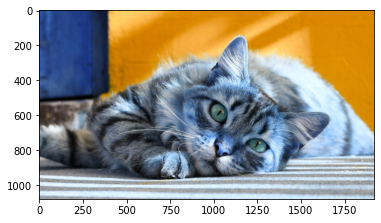

In [ ]:
# 특성 맵 정보를 가져올 이미지를 호출합니다.

img = cv2.imread('../content/cat.jpg')
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation = cv2.INTER_LINEAR)
img = ToTensor()(img).unsqueeze(0)
print(img.shape)

cv2.resize는 이미지 크기를 변경할 때 사용하며,
interpolation 파라미터는 보간법입니다.
이미지 크기를 변경할 경우 변형된 이미지의 픽셀을 추정해서 값을 할당해야 합니다. 이미지 비율을 변경하면 존재하지 않는 영역에 새로운 픽셀 값을 매핑하거나 존재하는 픽셀들을 압축해서 새로운 값을 할당해야 합니다. 이러한 상황을 피하고자 이미지상에 존재하는 픽셀 데이터들에 대해 근사함수를 적용해서 새로운 픽셀 값을 구하는 것이 보간법입니다.

unsqueeze()는 1차원 데이터를 생성하는 함수입니다. 즉, 이미지 데이터를 텐서로 변환하고, 그 변환된 데이터를 1차원으로 변경하겠다는 의미입니다.

In [ ]:
import torch

x1 = torch.rand(3, 10, 64)
x2 = x1.unsqueeze(dim = 0)
print(x2.shape)
x3 = x1.unsqueeze(dim = 1)
print(x3.shape)

torch.Size([1, 3, 10, 64])
torch.Size([3, 1, 10, 64])


In [ ]:
# Conv2d 특성 맵 확인

result = LayerActivation(model.features, 0)
model(img)
activations = result.features

<ipython-input-107-aeb2d9b68488>:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


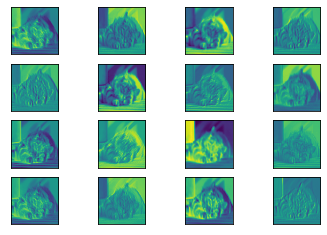

<Figure size 864x576 with 0 Axes>

In [ ]:
# 시각적으로 표현
fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize = (12, 8))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
for row in range(4):
  for column in range(4):
    axis = axes[row][column]
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])
    axis.imshow(activations[0][row*10+column])

plt.show()

In [ ]:
result = LayerActivation(model.features, 20) # 20번째 Conv2d 특성 맵 확인
model(img)
activations = result.features

<ipython-input-107-aeb2d9b68488>:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


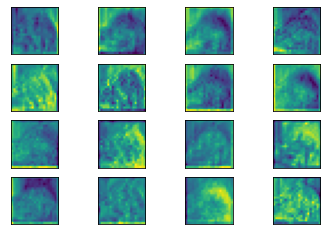

<Figure size 864x576 with 0 Axes>

In [ ]:
# 시각적으로 표현
fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize = (12, 8))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
for row in range(4):
  for column in range(4):
    axis = axes[row][column]
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])
    axis.imshow(activations[0][row*10+column])

plt.show()

In [ ]:
result = LayerActivation(model.features, 40) # 40번째 Conv2d 특성 맵 확인
model(img)
activations = result.features

<ipython-input-107-aeb2d9b68488>:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


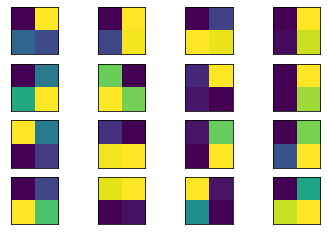

<Figure size 864x576 with 0 Axes>

In [ ]:
# 시각적으로 표현
fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize = (12, 8))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
for row in range(4):
  for column in range(4):
    axis = axes[row][column]
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])
    axis.imshow(activations[0][row*10+column])

plt.show()

이제 원래 입력 이미지에 대한 형태는 전혀 찾아볼 수 없습니다. 즉, 출력층에 가까울수록 원래 형태는 찾아볼 수 없고, 이미지 특징들만 전달되는 것을 확인할 수 있습니다.

### 그래프 합성곱 네트워크

그래프 합성곱 네트워크는 그래프 데이터를 위한 신경망입니다.

그래프란? : 그래프는 방향성이 있거나 없는 에지로 연결된 노드의 집합입니다. 여기에서 노드와 에지는 일반적으로 풀고자 하는 문제에 대한 전문가 지식이나 직관 등으로 구성됩니다.

에지는 두 노드를 연결한 선을 의미합니다.